<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/BayesianOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [0]:
np.random.seed(1)

## Define kernal function (RBF)

In [0]:
def kernel(X1, X2, param):
    sqdist = (X1-X2.T)**2
    return np.exp(-0.5*sqdist/param)

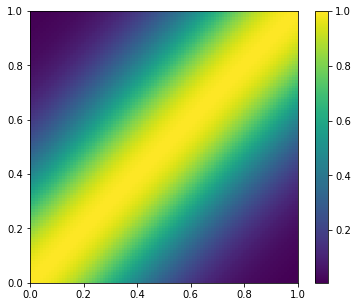

In [66]:
## example
plt.figure(figsize=(6,5))
x_tmp = np.linspace(0,1,100)
plt.pcolor(x_tmp, x_tmp, kernel(x_tmp.reshape(-1,1), x_tmp.reshape(-1,1), .1))
plt.colorbar()

## Compute Conditional Distribution

Use $_{0}$ to denote explored spaces, and $_{s}$ for space under search

The join kernel is given as
$K = \begin{pmatrix} K_{ss} & K_{s0}^T \\ K_{0s} & K_{00} \end{pmatrix}$,

where the old kernel is $K_{00}$ ans its cholesky decomposition is as

$K_{00} = LL^T$

The conditional distribution of new $y_s$ follows multivariate gaussian $$\mathcal{N}(\mu_s, \Sigma_s)$$, where

$$ \begin{split} \mu_s & = K_{s0}K_{00}^{-1}y_0 & = K_{s0}(L^{-1})^TL^{-1}y_0 \\
 & = (L^{-1}K_{s0}^T)^TL^{-1}y_0 & = (L^{-1}K_{0s})^TL^{-1}y_0\end{split}$$

 and $$\Sigma_s = K_{ss} - K_{s0}K_{00}^{-1}K{0s} = K_{ss} - K_{s0}(LL^T)^{-1}K_{0s}$$

Let $L_k = L^{-1}K_{0s}$, the above two equations can be written as

$$\mu_s = L_k^TL^{-1}y_0$$, 
$$\Sigma_s = K_{ss} - L_k^TL_k$$

The variance of individual $y$ is the diagonal component of $\Sigma_s$

In [0]:
def get_conditional_dist(x0, y0, xs, kernel_param):
    '''
    return the mu and standard deviation of conditional distribution of ys at xs given y0 at xs
    p(ys|y0)
    '''
    x0 = x0.reshape(-1,1)
    y0 = y0.reshape(-1,1)
    xs = xs.reshape(-1,1)
    
    K00 = kernel(x0, x0, kernel_param)
    Kss = kernel(xs, xs, kernel_param)
    K0s = kernel(x0, xs, kernel_param)
    
    L = np.linalg.cholesky(K00 + 1e-3*np.eye(K00.shape[0]))
    #solve conditional mu on x_candidate
    Lk = np.linalg.solve(L, K0s)
    mu_s = np.dot(Lk.T, np.linalg.solve(L,y0))

    #solve conditional variance on x_candidate
    var_s = np.diag(Kss) - np.sum(Lk**2, axis=0)
    sigma_s = np.sqrt(var_s)

    return mu_s.flatten(), sigma_s.flatten()

## Define acquisition functions
Given expected mean and variance, return an aggregated value

In [0]:
def get_score_fun(ftype = 'exploration_exploitation', **kwargs):
    '''
    ftype 
       exploration_exploitation: mu+kappa*sigma, kappa should be passed
       improvement_probability : probability of improvment. bestY value so far must be passed
       
    '''
    def exploration_exploitation_fun(mu, sigma):
        return mu+sigma*kappa
    def prob_improvement(mu, sigma, bestY):
        return 1-norm.cdf((bestY-mu)/sigma)
    
    if ftype=='exploration_exploitation':
        kappa = kwargs['kappa'] if 'kappa' in kwargs else 1
        return exploration_exploitation_fun
    elif ftype == 'improvement_probability':
        #bestY = kwargs['bestY'] if 'bestY' in kwargs else 0
        return prob_improvement

## Define the true function (noiseless)

In [0]:
def myfun(x):
    return np.cos(x)*np.sin(10*x)+np.exp(-(x-1.0)**2*100.0)*2.0

## Baysian Optimization Workflow

In [0]:
def plot_progress(x_true, y_true, x0, y0, x_candidate,  mu, sigma, score, xs, ys, verbose):
    plt.plot(x_true, y_true,'--',label='truth')
    plt.plot(x0, y0,'.', markersize=15, label='x0')
    plt.plot(xs, ys,'g.', markersize=15, label='xs')
    plt.plot(x_candidate, score-2, label='score')
    plt.fill_between(x_for_plot, mu-2*sigma, mu+2*sigma, color = '#dddddd')
    if verbose:
        plt.legend()

In [0]:
## get acquisition score
#score_fun = get_score_fun(ftype = 'exploration_exploitation', kappa = 2) #bigger kappa means more exploration
score_fun = get_score_fun(ftype = 'improvement_probability') # select candidate based on which one has the largest probability of beating the best solution so far

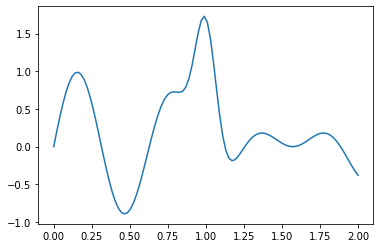

In [341]:
n_iteration = 15
x_range = [0,2]
kernel_param = 0.02

## example
x_true = np.linspace(x_range[0], x_range[1],100)
y_true = myfun(x_true)
plt.plot(x_true, y_true)

In [0]:
## 1. Init
x0 = np.sort(np.random.rand(2,1),axis=0)
y0 = myfun(x0)

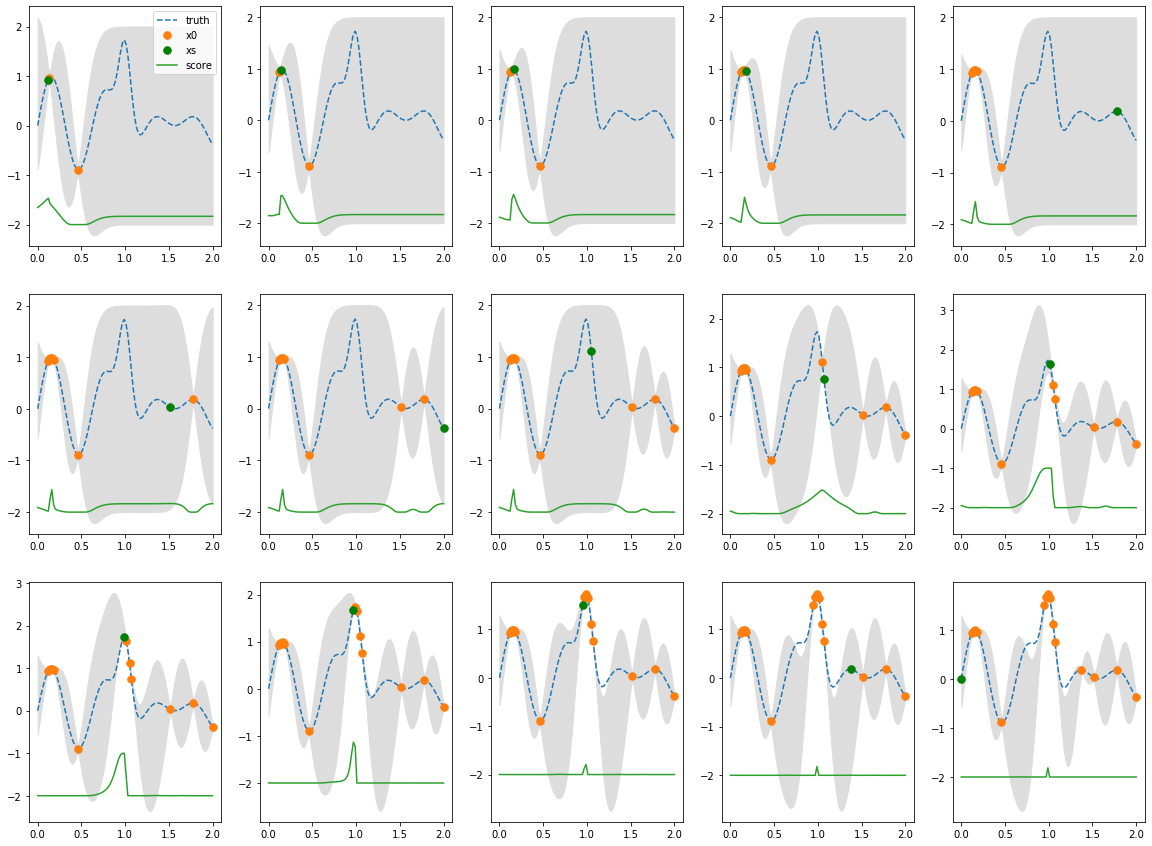

In [343]:
plt.figure(figsize=(20,15))

for i in range(n_iteration):
    # get candidate
    x_candidate = np.linspace(x_range[0],x_range[1], 100)

    #estimate conditional distribution
    mu, sigma = get_conditional_dist(x0, y0, x_candidate, kernel_param)

    #get score
    #score = score_fun(mu,sigma)
    score = score_fun(mu,sigma, y0.max())

    #select xs that gives highest score and has not been explored yet
    ind_sort = np.argsort(score)[::-1]
    ind_select = np.where(~np.in1d(x_candidate[ind_sort], x0))[0][0]
    ind_select = ind_sort[ind_select]
    xs = x_candidate[ind_select]

    #evaluate at xs
    ys = myfun(xs)

    plt.subplot(3,5,i+1)
    #x_for_plot = np.linspace(x_range[0],x_range[1], 100)
    #mu_for_plot, sigma_for_plot = get_conditional_dist(x0, y0, x_for_plot, kernel_param)
    plot_progress(x_true, y_true, x0, y0, x_candidate, mu, sigma, score, xs, ys, True if i==0 else False)

    #append to explored data
    x0 = np.append(x0,xs)
    y0 = np.append(y0,ys)